<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/S10_Trial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [2]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-uajin3jm
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-uajin3jm
     |████████████████████████████████| 634kB 1.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=b4dbeefd58c3b143822ac7039665be59c20f7f912ffb65877ed57e04d92bc758
  Stored in directory: /tmp/pip-ephem-wheel-cache-bg9stl7a/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=abb1526320c8fc424a4580ab31fa5aad86407926c39f466cfea962437b86fd96
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [3]:
# mount gdrive and unzip data
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount=True)
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [5]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



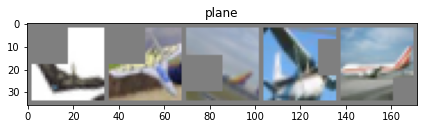

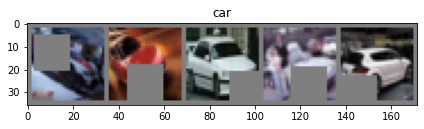

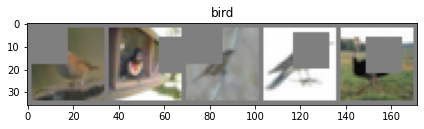

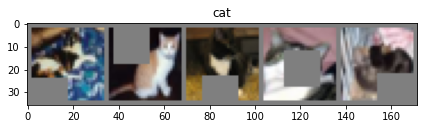

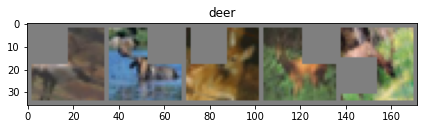

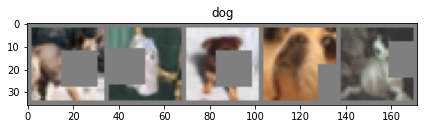

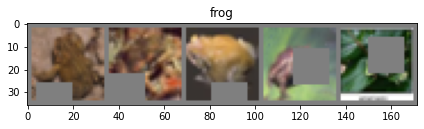

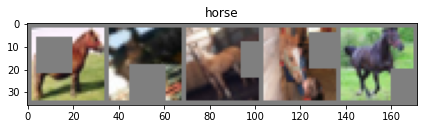

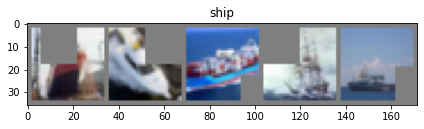

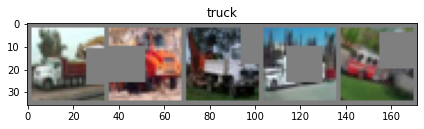

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.00005)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=500 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


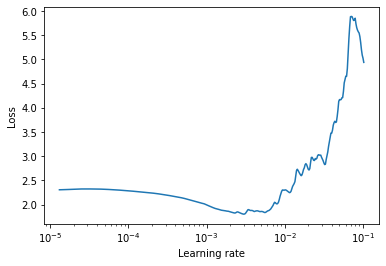

In [10]:
lrfinder.plot()


In [13]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(Best_lr)

0.0030199517204020157


In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.00005)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, min_lr=1e-4)

In [17]:
testLoss = []
testAcc = []
EPOCHS = 50
#best_acc1 = 10
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
     scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0030199517204020157


Loss=1.3494603633880615 Batch_id=390 Accuracy=43.08: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5738/10000 (57.38%)

EPOCH: 2 LR: 0.0030199517204020157


Loss=1.0111339092254639 Batch_id=390 Accuracy=56.94: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6439/10000 (64.39%)

EPOCH: 3 LR: 0.0030199517204020157


Loss=0.9648019075393677 Batch_id=390 Accuracy=63.35: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 6823/10000 (68.23%)

EPOCH: 4 LR: 0.0030199517204020157


Loss=0.938519299030304 Batch_id=390 Accuracy=67.86: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7475/10000 (74.75%)

EPOCH: 5 LR: 0.0030199517204020157


Loss=1.0224030017852783 Batch_id=390 Accuracy=70.24: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7438/10000 (74.38%)

EPOCH: 6 LR: 0.0030199517204020157


Loss=0.9280117750167847 Batch_id=390 Accuracy=72.86: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7879/10000 (78.79%)

EPOCH: 7 LR: 0.0030199517204020157


Loss=0.6910141110420227 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7952/10000 (79.52%)

EPOCH: 8 LR: 0.0030199517204020157


Loss=0.6460326910018921 Batch_id=390 Accuracy=75.91: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8036/10000 (80.36%)

EPOCH: 9 LR: 0.0030199517204020157


Loss=0.610813319683075 Batch_id=390 Accuracy=77.12: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8224/10000 (82.24%)

EPOCH: 10 LR: 0.0030199517204020157


Loss=0.6928147077560425 Batch_id=390 Accuracy=78.28: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8097/10000 (80.97%)

EPOCH: 11 LR: 0.0030199517204020157


Loss=0.548947811126709 Batch_id=390 Accuracy=79.44: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7975/10000 (79.75%)

EPOCH: 12 LR: 0.0030199517204020157


Loss=0.8073968887329102 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8386/10000 (83.86%)

EPOCH: 13 LR: 0.0030199517204020157


Loss=0.5447643995285034 Batch_id=390 Accuracy=81.05: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8507/10000 (85.07%)

EPOCH: 14 LR: 0.0030199517204020157


Loss=0.4119759202003479 Batch_id=390 Accuracy=81.66: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8476/10000 (84.76%)

EPOCH: 15 LR: 0.0030199517204020157


Loss=0.48542794585227966 Batch_id=390 Accuracy=82.38: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8551/10000 (85.51%)

EPOCH: 16 LR: 0.0030199517204020157


Loss=0.3945637047290802 Batch_id=390 Accuracy=82.75: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8418/10000 (84.18%)

EPOCH: 17 LR: 0.0030199517204020157


Loss=0.5044995546340942 Batch_id=390 Accuracy=83.62: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8725/10000 (87.25%)

EPOCH: 18 LR: 0.0030199517204020157


Loss=0.3411722779273987 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8489/10000 (84.89%)

EPOCH: 19 LR: 0.0030199517204020157


Loss=0.27768561244010925 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8704/10000 (87.04%)

EPOCH: 20 LR: 0.0030199517204020157


Loss=0.3714640736579895 Batch_id=390 Accuracy=85.14: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8584/10000 (85.84%)

EPOCH: 21 LR: 0.0030199517204020157


Loss=0.39950352907180786 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8646/10000 (86.46%)

EPOCH: 22 LR: 0.0003019951720402016


Loss=0.3495468199253082 Batch_id=390 Accuracy=88.17: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8991/10000 (89.91%)

EPOCH: 23 LR: 0.0003019951720402016


Loss=0.22570744156837463 Batch_id=390 Accuracy=89.08: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8991/10000 (89.91%)

EPOCH: 24 LR: 0.0003019951720402016


Loss=0.259044349193573 Batch_id=390 Accuracy=89.49: 100%|██████████| 391/391 [00:29<00:00, 13.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9018/10000 (90.18%)

EPOCH: 25 LR: 0.0003019951720402016


Loss=0.19545681774616241 Batch_id=390 Accuracy=89.79: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9012/10000 (90.12%)

EPOCH: 26 LR: 0.0003019951720402016


Loss=0.2651304602622986 Batch_id=390 Accuracy=89.90: 100%|██████████| 391/391 [00:29<00:00, 13.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9026/10000 (90.26%)

EPOCH: 27 LR: 0.0003019951720402016


Loss=0.4104131758213043 Batch_id=390 Accuracy=90.02: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9046/10000 (90.46%)

EPOCH: 28 LR: 0.0003019951720402016


Loss=0.3250132203102112 Batch_id=390 Accuracy=90.20: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9043/10000 (90.43%)

EPOCH: 29 LR: 0.0003019951720402016


Loss=0.4392601549625397 Batch_id=390 Accuracy=90.37: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9052/10000 (90.52%)

EPOCH: 30 LR: 0.0003019951720402016


Loss=0.20233407616615295 Batch_id=390 Accuracy=90.54: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9050/10000 (90.50%)

EPOCH: 31 LR: 0.0003019951720402016


Loss=0.2688683271408081 Batch_id=390 Accuracy=90.71: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9066/10000 (90.66%)

EPOCH: 32 LR: 0.0003019951720402016


Loss=0.2557576298713684 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9049/10000 (90.49%)

EPOCH: 33 LR: 0.0003019951720402016


Loss=0.34041017293930054 Batch_id=390 Accuracy=90.97: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9062/10000 (90.62%)

EPOCH: 34 LR: 0.0003019951720402016


Loss=0.18697835505008698 Batch_id=390 Accuracy=90.93: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9057/10000 (90.57%)

EPOCH: 35 LR: 0.0003019951720402016


Loss=0.2268596589565277 Batch_id=390 Accuracy=91.00: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9072/10000 (90.72%)

EPOCH: 36 LR: 0.0003019951720402016


Loss=0.30012065172195435 Batch_id=390 Accuracy=91.20: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9055/10000 (90.55%)

EPOCH: 37 LR: 0.0003019951720402016


Loss=0.4904528558254242 Batch_id=390 Accuracy=91.16: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9054/10000 (90.54%)

EPOCH: 38 LR: 0.0003019951720402016


Loss=0.1754932850599289 Batch_id=390 Accuracy=91.17: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9056/10000 (90.56%)

EPOCH: 39 LR: 0.0003019951720402016


Loss=0.36268511414527893 Batch_id=390 Accuracy=91.35: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9038/10000 (90.38%)

EPOCH: 40 LR: 0.0001


Loss=0.34160909056663513 Batch_id=390 Accuracy=91.65: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9068/10000 (90.68%)

EPOCH: 41 LR: 0.0001


Loss=0.26400336623191833 Batch_id=390 Accuracy=91.81: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9065/10000 (90.65%)

EPOCH: 42 LR: 0.0001


Loss=0.17183411121368408 Batch_id=390 Accuracy=91.77: 100%|██████████| 391/391 [00:29<00:00, 13.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9079/10000 (90.79%)

EPOCH: 43 LR: 0.0001


Loss=0.21596074104309082 Batch_id=390 Accuracy=91.79: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9085/10000 (90.85%)

EPOCH: 44 LR: 0.0001


Loss=0.34884876012802124 Batch_id=390 Accuracy=91.97: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9082/10000 (90.82%)

EPOCH: 45 LR: 0.0001


Loss=0.22168032824993134 Batch_id=390 Accuracy=92.07: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9091/10000 (90.91%)

EPOCH: 46 LR: 0.0001


Loss=0.27115750312805176 Batch_id=390 Accuracy=91.88: 100%|██████████| 391/391 [00:29<00:00, 13.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9087/10000 (90.87%)

EPOCH: 47 LR: 0.0001


Loss=0.25476354360580444 Batch_id=390 Accuracy=92.01: 100%|██████████| 391/391 [00:29<00:00, 13.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9075/10000 (90.75%)

EPOCH: 48 LR: 0.0001


Loss=0.2323206663131714 Batch_id=390 Accuracy=91.89: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9086/10000 (90.86%)

EPOCH: 49 LR: 0.0001


Loss=0.18934981524944305 Batch_id=390 Accuracy=91.95: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9079/10000 (90.79%)

EPOCH: 50 LR: 0.0001


Loss=0.17956268787384033 Batch_id=390 Accuracy=92.26: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]



Test set: Average loss: 0.0023, Accuracy: 9096/10000 (90.96%)



In [18]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 90.960 %


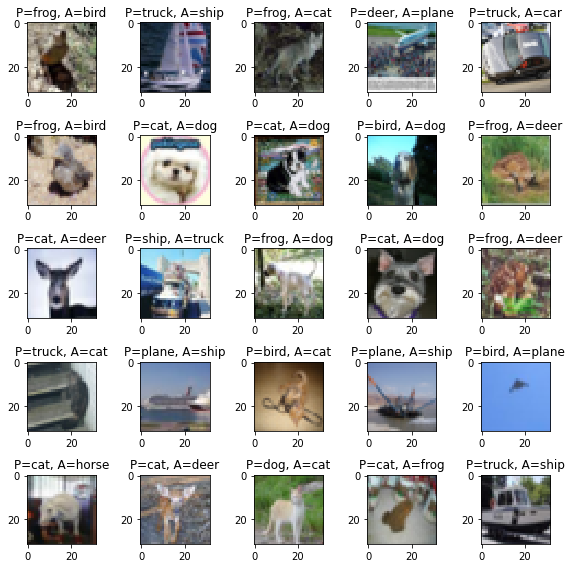

In [19]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [20]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 96 %
Accuracy of   car : 97 %
Accuracy of  bird : 83 %
Accuracy of   cat : 77 %
Accuracy of  deer : 93 %
Accuracy of   dog : 96 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 87 %
Accuracy of truck : 96 %


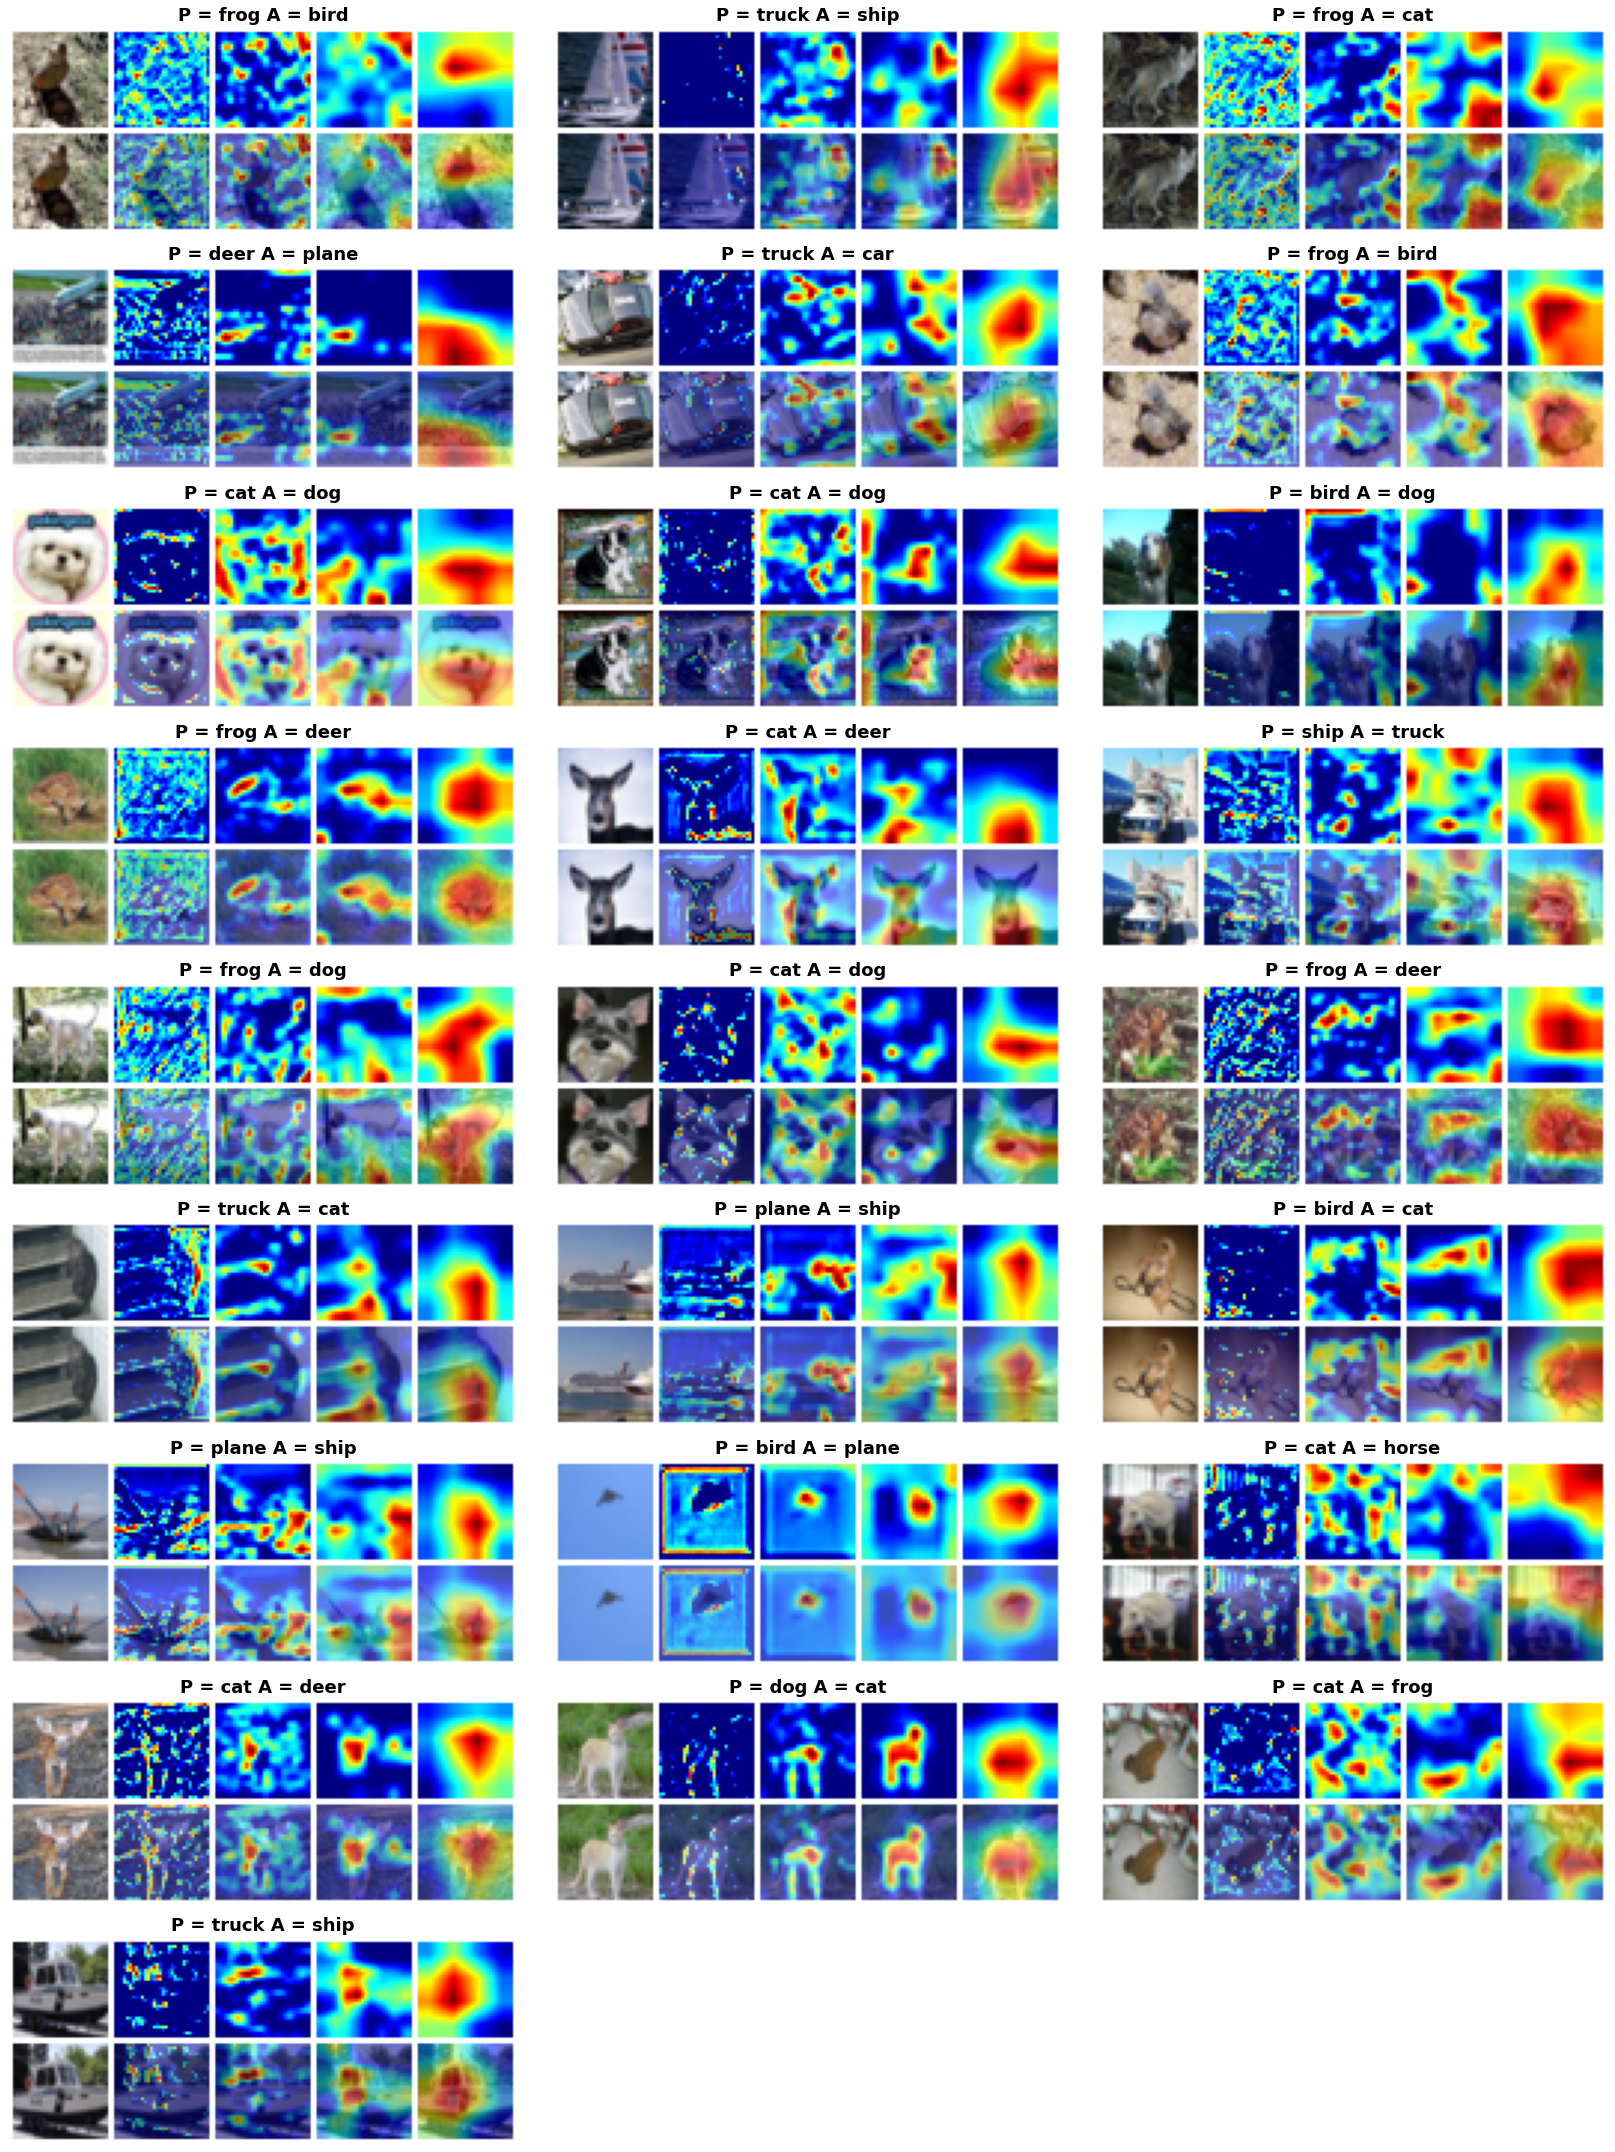

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)